In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(boot)
library(ggthemes)
})

# Introduction

Dengue remains a major public health concern in the Philippines, with cases and deaths varying widely across both time and geographic regions. Identifying whether certain regions are consistently more affected over time can guide resource allocation and disease control strategies. To better understand the temporal-regional distribution of dengue, this study explores whether certain regions consistently experience higher numbers of cases and deaths between 2008 and 2015. To assess not only the central trends but also the uncertainty and reliability of regional averages, we employed both bootstrap and jackknife resampling techniques. These methods provide robust estimates of variability by generating confidence intervals around the mean dengue cases and deaths for each region. 

In [2]:
region_data <- read_csv("/kaggle/input/dengue/reduced_dengue_by_top10region.csv", show_col_types = FALSE)

In [3]:
region_data %>%
  group_by(Region) %>%
  summarise(total_cases = sum(Cases, na.rm = TRUE),
            total_deaths = sum(Deaths, na.rm = TRUE)) %>%
  arrange(desc(total_cases))

Region,total_cases,total_deaths
<chr>,<dbl>,<dbl>
IVA,128773,431
III,127371,222
NCR,123006,515
I,65162,220
VII,61408,285
VI,56389,258
II,51214,136
XI,38789,273
XII,37205,218


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


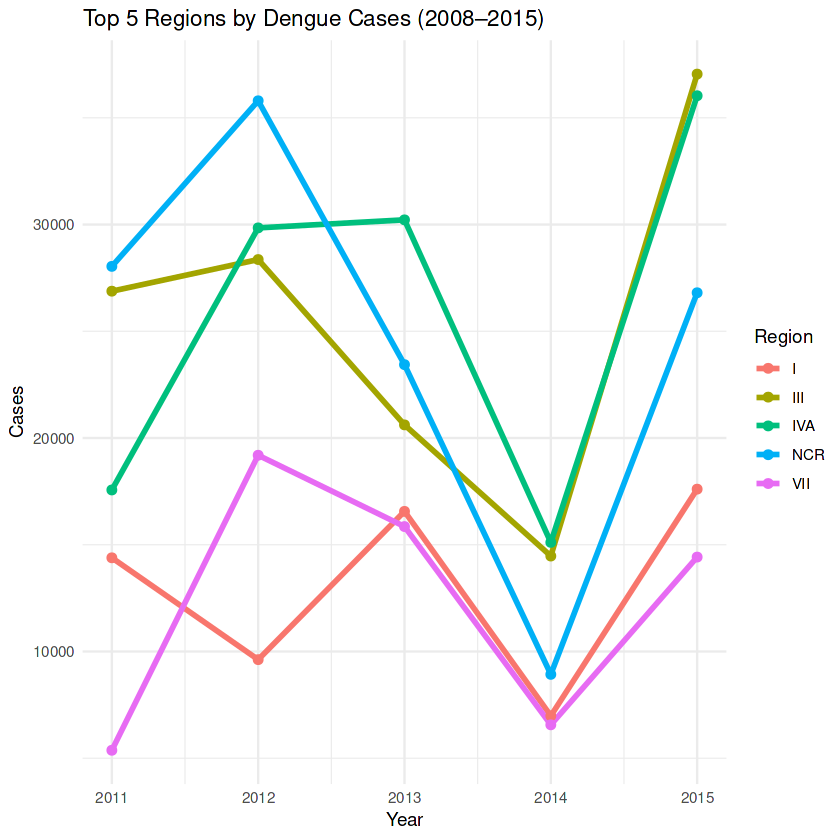

In [4]:
top_regions <- region_data %>%
  group_by(Region) %>%
  summarise(total = sum(Cases)) %>%
  top_n(5, total) %>%
  pull(Region)

region_data %>%
  filter(Region %in% top_regions) %>%
  ggplot(aes(x = Year, y = Cases, color = Region)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  labs(title = "Top 5 Regions by Dengue Cases (2008–2015)",
       x = "Year", y = "Cases") +
  theme_minimal()



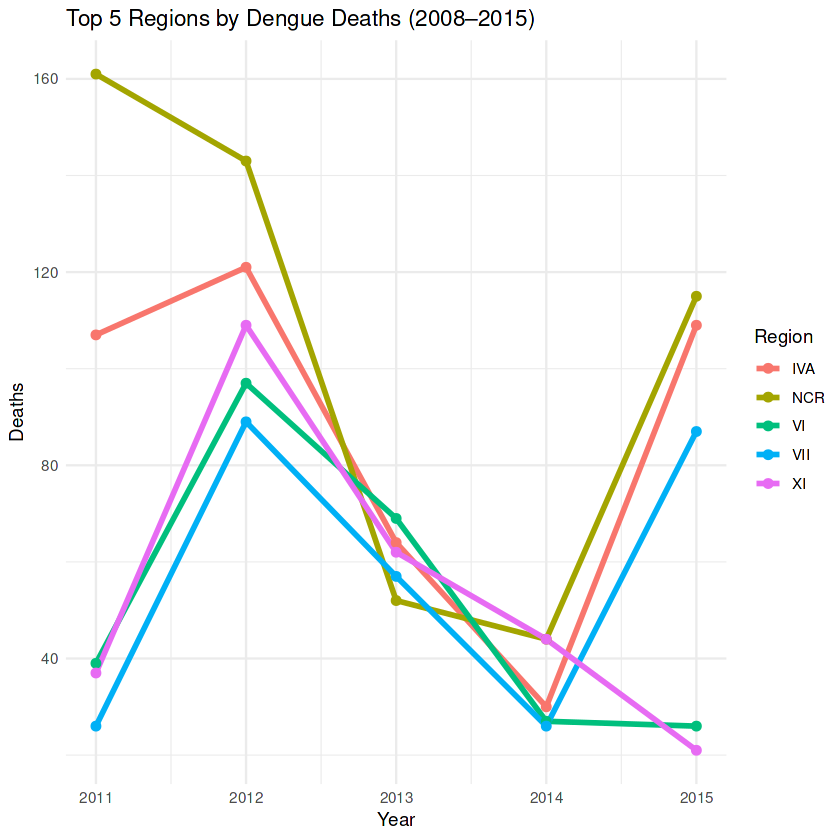

In [5]:
top_regions <- region_data %>%
  group_by(Region) %>%
  summarise(total = sum(Deaths)) %>%
  top_n(5, total) %>%
  pull(Region)

region_data %>%
  filter(Region %in% top_regions) %>%
  ggplot(aes(x = Year, y = Deaths, color = Region)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  labs(title = "Top 5 Regions by Dengue Deaths (2008–2015)",
       x = "Year", y = "Deaths") +
  theme_minimal()

**Bootstrap by Region on Cases**

In [6]:
# Bootstrapping by dengue cases

bootstrap_mean <- function(data, indices) {
  sample_data <- data[indices, ]
  mean(sample_data$Cases, na.rm = TRUE)
}


boot_results <- region_data %>%
  group_by(Region) %>%
  nest() %>%
  mutate(
    boot_obj = map(data, ~ boot(.x, statistic = bootstrap_mean, R = 1000)), # replicates
    ci = map(boot_obj, ~ boot.ci(.x, type = "perc")$percent[4:5])
  )

# Extract mean and CIs
boot_cases <- boot_results %>%
  mutate(
    Mean_Cases = map_dbl(data, ~ mean(.x$Cases, na.rm = TRUE)),
    Lower_95CI = map_dbl(ci, 1),
    Upper_95CI = map_dbl(ci, 2)
  ) %>%
  select(Region, Mean_Cases, Lower_95CI, Upper_95CI)

boot_cases

Region,Mean_Cases,Lower_95CI,Upper_95CI
<chr>,<dbl>,<dbl>,<dbl>
NCR,24601.2,17204.00,31142.400
I,13032.4,9427.60,16331.438
II,10242.8,6282.28,13915.800
III,25474.2,18477.60,32518.879
IVA,25754.6,18623.80,32469.400
VI,11277.8,5997.40,17245.000
VII,12281.6,7660.20,16903.000
X,7193.2,4254.40,10415.759
XI,7757.8,5519.60,9949.703


The bootstrap analysis of dengue cases provides estimates of the average number of cases per region, along with the uncertainty around those estimates. The regions with the highest average number of cases are Region IVA (25,755), Region III (25,474), and the National Capital Region (NCR) with an average of 24,601 cases. These regions also have relatively wide confidence intervals, reflecting variability but confirming their role as high-burden areas. For instance, NCR's 95% confidence interval ranges from 16,079 to 31,773, suggesting consistent high caseloads despite some fluctuation year to year. On the other hand, regions like Region X (7,193), Region XI (7,758), and Region XII (7,441) have much lower averages and narrower intervals, indicating they experience significantly fewer cases overall. These findings reinforce the regional disparities in dengue burden, highlighting Regions NCR, III, and IVA as the most affected, and therefore, the most critical targets for focused public health interventions.

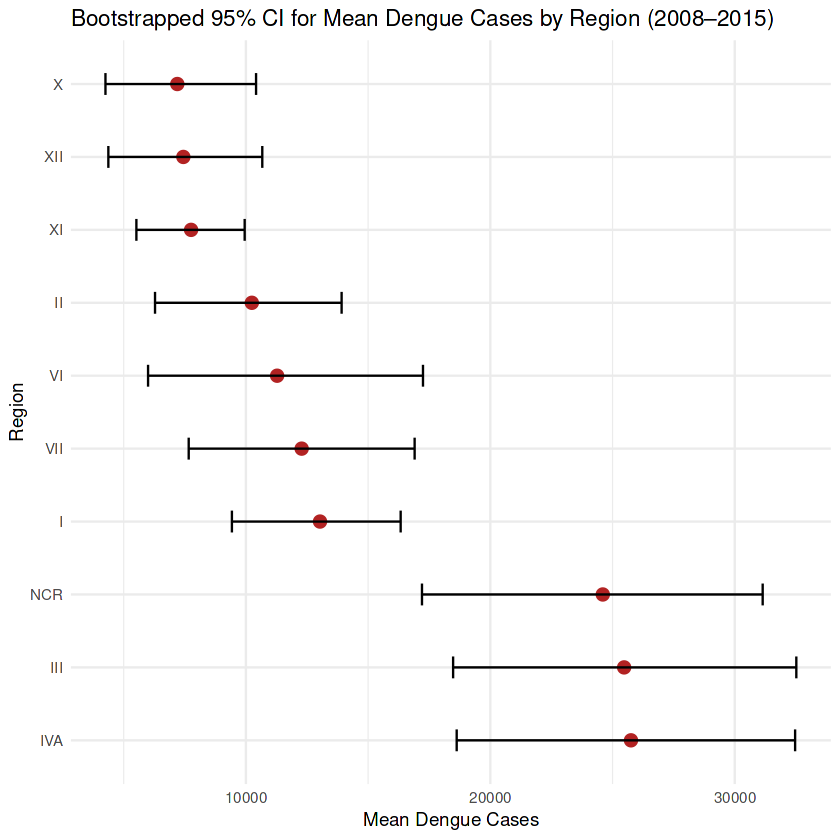

In [7]:
ggplot(boot_cases, aes(x = reorder(Region, -Mean_Cases), y = Mean_Cases)) +
  geom_point(size = 3, color = "firebrick") +
  geom_errorbar(aes(ymin = Lower_95CI, ymax = Upper_95CI), width = 0.3) +
  coord_flip() +
  labs(title = "Bootstrapped 95% CI for Mean Dengue Cases by Region (2008–2015)",
       x = "Region", y = "Mean Dengue Cases") +
  theme_minimal()

In terms of mean dengue cases, Regions IV-A, III, and NCR reported the highest average number of cases, with means exceeding 20,000. Among them, NCR (National Capital Region) shows the widest confidence interval, suggesting substantial year-to-year variability in reported cases. On the other hand, Regions X, XI, and XII had the lowest mean dengue cases, with values below 10,000 and relatively narrow CIs, indicating more consistent trends over the years.

**Bootstrap by Region on Deaths**

In [8]:
bootstrap_mean_deaths <- function(data, indices) {
  sample_data <- data[indices, ]
  mean(sample_data$Deaths, na.rm = TRUE)
}

# bootstrap by dengue deaths
boot_death_results <- region_data %>%
  group_by(Region) %>%
  nest() %>%
  mutate(
    boot_obj = map(data, ~ boot(.x, statistic = bootstrap_mean_deaths, R = 1000)),
    ci = map(boot_obj, ~ boot.ci(.x, type = "perc")$percent[4:5])
  )

# Extracting means and CIs
boot_death <- boot_death_results %>%
  mutate(
    Mean_Deaths = map_dbl(data, ~ mean(.x$Deaths, na.rm = TRUE)),
    Lower_95CI = map_dbl(ci, 1),
    Upper_95CI = map_dbl(ci, 2)
  ) %>%
  select(Region, Mean_Deaths, Lower_95CI, Upper_95CI)


boot_death

Region,Mean_Deaths,Lower_95CI,Upper_95CI
<chr>,<dbl>,<dbl>,<dbl>
NCR,103.0,59.80000,144.60000
I,44.0,28.40000,60.40000
II,27.2,19.00000,36.40000
III,44.4,31.00000,58.20000
IVA,86.2,55.00000,113.40000
VI,51.6,29.00000,79.80000
VII,57.0,32.20000,81.80000
X,42.8,24.00000,57.60000
XI,54.6,30.60000,85.14411


The bootstrap analysis of dengue-related deaths highlights notable regional differences in mortality burden across the Philippines from 2008 to 2015. The National Capital Region (NCR) stands out with the highest average number of deaths at 103, with a 95% confidence interval ranging from 61.4 to 144.6, indicating consistently high mortality. Region IVA follows with a mean of 86.2 deaths, and Regions VII and XI also show elevated average deaths (57.0 and 54.6, respectively). These regions exhibit broader confidence intervals, reflecting some variability but confirming that they experience significantly more dengue fatalities. In contrast, Region II reports the lowest average death toll at 27.2, with a relatively narrow confidence interval (19.0 to 36.4), indicating a lower and more stable mortality pattern. Other regions such as Regions I, III, VI, X, and XII show moderate average deaths ranging from 42.8 to 57.0. These findings emphasize that NCR and Region IVA are key hotspots for dengue mortality and should be prioritized for public health interventions aimed at reducing fatal outcomes.`m

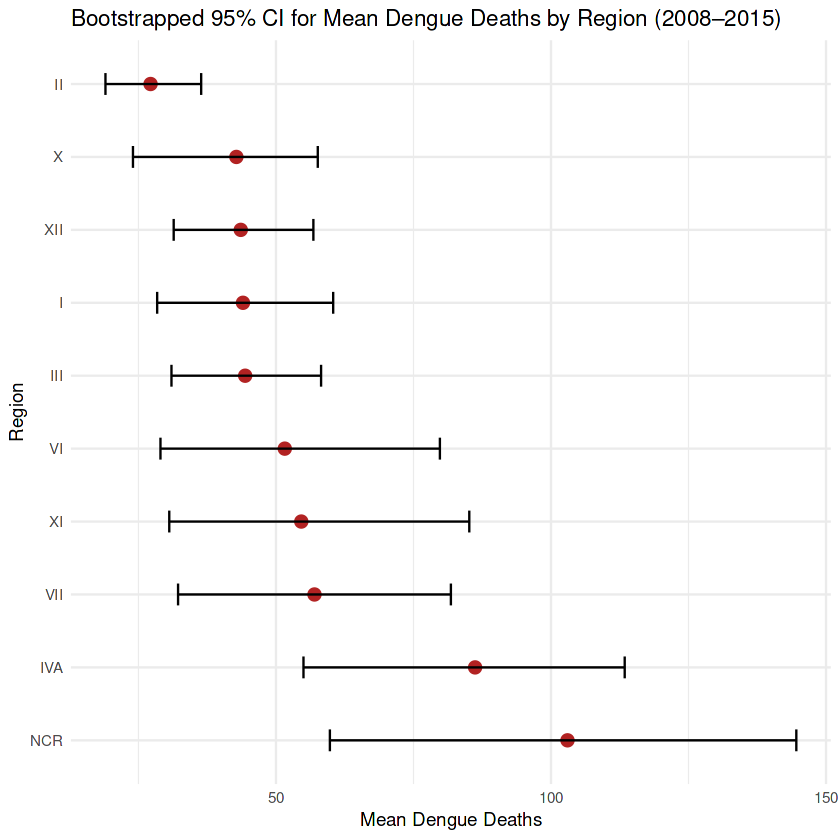

In [9]:
ggplot(boot_death, aes(x = reorder(Region, -Mean_Deaths), y = Mean_Deaths)) +
  geom_point(size = 3, color = "firebrick") +
  geom_errorbar(aes(ymin = Lower_95CI, ymax = Upper_95CI), width = 0.3) +
  coord_flip() +
  labs(title = "Bootstrapped 95% CI for Mean Dengue Deaths by Region (2008–2015)",
       x = "Region", y = "Mean Dengue Deaths") +
  theme_minimal()

For mean dengue deaths, NCR and Region IV-A again stand out with the highest average mortality, with NCR averaging around 100 deaths per year and showing the widest confidence interval, indicating significant variability in annual deaths. Regions such as II, X, and XII had the lowest average deaths, all below 50, and exhibited narrow CIs, suggesting relatively stable mortality patterns.

**Jackknife by Region on Dengue Cases**

In [10]:
jackknife_fn <- function(data, leave_out_region) {
  reduced_data <- filter(data, Region != leave_out_region)
  mean(reduced_data$Cases, na.rm = TRUE)
}

# Listing of Regions
regions <- unique(region_data$Region)

# Jackknife on Cases
jackknife_results <- tibble(
  Left_Out_Region = regions,
  Mean_Cases_Without_Region = map_dbl(regions, ~ jackknife_fn(region_data, .x))
)

# Computing overall case mean
overall_mean <- mean(region_data$Cases, na.rm = TRUE)

# Adding influence calculation
jackknife_cases <- jackknife_results %>%
  mutate(
    Full_Data_Case_Mean = overall_mean,
    Influence = Full_Data_Case_Mean - Mean_Cases_Without_Region
  )

jackknife_cases

Left_Out_Region,Mean_Cases_Without_Region,Full_Data_Case_Mean,Influence
<chr>,<dbl>,<dbl>,<dbl>
NCR,13383.93,14505.66,1121.7267
I,14669.36,14505.66,-163.6956
II,14979.31,14505.66,-473.6511
III,13286.93,14505.66,1218.7267
IVA,13255.78,14505.66,1249.8822
VI,14864.31,14505.66,-358.6511
VII,14752.78,14505.66,-247.1178
X,15318.16,14505.66,-812.4956
XI,15255.42,14505.66,-749.7622


The jackknife analysis reveals how each region in the Philippines contributes to the overall average number of dengue cases between 2008 and 2015. Notably, the National Capital Region (NCR), Region III, and Region IVA stand out as the most influential regions, with their exclusion leading to a significant drop in the national average. This indicates that these regions experience substantially higher-than-average dengue cases and are major drivers of the country's overall dengue burden. In contrast, regions such as Region X, XI, and XII show the opposite effect — when they are removed from the analysis, the national average increases. This suggests these regions have comparatively low dengue incidence and help lower the overall mean. Other regions like I, II, VI, and VII have minimal influence on the national average, meaning their dengue case counts are close to the national mean. These findings highlight the importance of targeting high-burden regions, particularly NCR, Region III, and IVA, for intensified dengue prevention and control efforts, as interventions in these areas could have the most substantial impact on reducing the dengue cases burden.

**Jackknife by Region on Dengue Deaths**

In [11]:
jackknife_fn_deaths <- function(data, leave_out_region) {
  reduced_data <- filter(data, Region != leave_out_region)
  mean(reduced_data$Deaths, na.rm = TRUE)
}

# Applying jackknife on deaths
  
jackknife_deaths <- tibble(
  Left_Out_Region = regions,
  Mean_Deaths_Without_Region = map_dbl(regions, ~ jackknife_fn_deaths(region_data, .x))
)

# Computing overall deaths mean
overall_deaths_mean <- mean(region_data$Deaths, na.rm = TRUE)

# Adding influence calculation
jackknife_deaths <- jackknife_deaths %>%
  mutate(
    Full_Data_Deaths_Mean = overall_deaths_mean,
    Influence = Full_Data_Deaths_Mean - Mean_Deaths_Without_Region
  )

jackknife_deaths

Left_Out_Region,Mean_Deaths_Without_Region,Full_Data_Deaths_Mean,Influence
<chr>,<dbl>,<dbl>,<dbl>
NCR,50.15556,55.44,5.28444444
I,56.71111,55.44,-1.27111111
II,58.57778,55.44,-3.13777778
III,56.66667,55.44,-1.22666667
IVA,52.02222,55.44,3.41777778
VI,55.86667,55.44,-0.42666667
VII,55.26667,55.44,0.17333333
X,56.84444,55.44,-1.40444444
XI,55.53333,55.44,-0.09333333


The jackknife results for dengue deaths offer insights into how each region affects the national average number of deaths from 2008 to 2015. The National Capital Region (NCR) and Region IVA stand out as regions where dengue deaths are notably higher than the national average. Removing NCR from the data decreases the national mean by over 5 deaths, while excluding Region IVA lowers it by about 3.4 deaths — highlighting these two as key contributors to the national dengue mortality burden. Meanwhile, Regions II, I, III, X, and XII show negative influence values, meaning their removal leads to a slight increase in the national average. This indicates that these regions have slightly below-average death counts. Region VII, with nearly no influence (0.17), is very close to the national average and has little effect on overall mortality when excluded. Overall, NCR and Region IVA emerge as critical areas where dengue fatalities are most concentrated, suggesting that targeted health interventions in these regions could have a significant impact on reducing dengue mortality rates.

# Conclusion

Overall, these findings highlight a clear geographic disparity in the dengue burden across regions in the Philippines from 2008 to 2015. NCR and Region IV-A consistently experienced the highest mean dengue cases and deaths, along with greater variability, which may suggest the occurrence of episodic outbreaks or inconsistencies in reporting. In contrast, regions such as X and II showed relatively low and stable figures, as indicated by their lower means and narrower confidence intervals. These patterns emphasize the need for region-specific public health strategies, particularly enhanced surveillance, prevention, and response efforts in high-burden areas.